In [3]:
# Install dependencies
!pip install rasterio scikit-image matplotlib

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3984359116.py:46: RuntimeWarning: invalid value encountered in arccos
  H = np.arccos(num / (den + 1e-8))


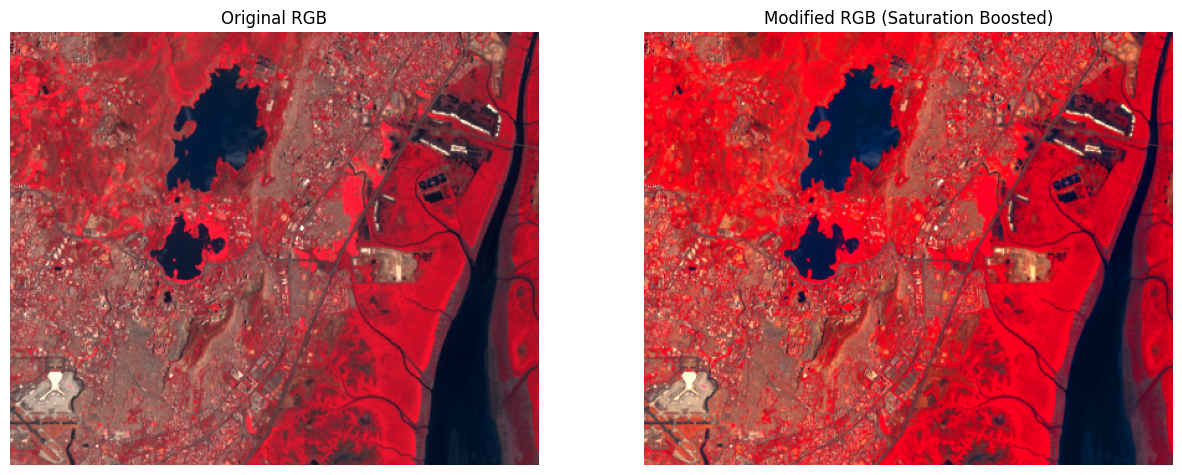

In [5]:
# Imports
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, img_as_ubyte


# -----------------------------
# Load the Landsat 8 subset
# -----------------------------
file_path = '/content/drive/MyDrive/sip_mum_sub/mumbai_subset_sip'  # Include .tif extension

with rasterio.open(file_path) as dataset:
    # Select RGB bands for Landsat 8 (B5, B4, B3 in your original code)
    band_indices = [5, 4, 3]
    rgb_bands = [dataset.read(b) for b in band_indices]

    # Stack bands into a 3D array
    rgb = np.dstack(rgb_bands).astype(np.float32)

    # Normalize based on data type
    if dataset.dtypes[0] == 'uint16':
        rgb /= 65535.0
    elif dataset.dtypes[0] == 'uint8':
        rgb /= 255.0

# -----------------------------
# Linear 2%-98% Percent Stretch
# -----------------------------
def linear2_percent_stretch(image):
    p2, p98 = np.percentile(image, (2, 98), axis=(0, 1))
    stretched = exposure.rescale_intensity(image, in_range=(p2.min(), p98.max()), out_range=(0, 1))
    return stretched

rgb = linear2_percent_stretch(rgb)

# -----------------------------
# RGB to HSI
# -----------------------------
def rgb_to_hsi(image):
    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    I = (R + G + B) / 3
    S = 1 - np.min(image, axis=2) / (I + 1e-8)
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B)*(G - B))
    H = np.arccos(np.clip(num / (den + 1e-8), -1, 1))
    H[B > G] = 2 * np.pi - H[B > G]
    H /= 2 * np.pi  # Normalize to [0,1]
    return H, S, I

H, S, I = rgb_to_hsi(rgb)

# -----------------------------
# Modify HSI (Boost Saturation)
# -----------------------------
S = np.clip(S * 1.7, 0, 1)

# -----------------------------
# Vectorized HSI to RGB Conversion
# -----------------------------
def hsi_to_rgb_vectorized(H, S, I):
    H_deg = H * 360
    R = np.zeros_like(H)
    G = np.zeros_like(H)
    B = np.zeros_like(H)

    # Sector 0° <= H < 120°
    mask = (H_deg < 120)
    B[mask] = I[mask] * (1 - S[mask])
    R[mask] = I[mask] * (1 + S[mask] * np.cos(np.radians(H_deg[mask])) / np.cos(np.radians(60 - H_deg[mask])))
    G[mask] = 3*I[mask] - (R[mask] + B[mask])

    # Sector 120° <= H < 240°
    mask = (H_deg >= 120) & (H_deg < 240)
    h = H_deg[mask] - 120
    R[mask] = I[mask] * (1 - S[mask])
    G[mask] = I[mask] * (1 + S[mask] * np.cos(np.radians(h)) / np.cos(np.radians(60 - h)))
    B[mask] = 3*I[mask] - (R[mask] + G[mask])

    # Sector 240° <= H < 360°
    mask = (H_deg >= 240)
    h = H_deg[mask] - 240
    G[mask] = I[mask] * (1 - S[mask])
    B[mask] = I[mask] * (1 + S[mask] * np.cos(np.radians(h)) / np.cos(np.radians(60 - h)))
    R[mask] = 3*I[mask] - (G[mask] + B[mask])

    return np.stack([R, G, B], axis=2)

modified_rgb = hsi_to_rgb_vectorized(H, S, I)
modified_rgb = np.clip(modified_rgb, 0, 1)
modified_rgb = img_as_ubyte(modified_rgb)

# -----------------------------
# Plot Original & Modified Images
# -----------------------------
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title("Original RGB")
plt.imshow(rgb)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Modified RGB (Saturation Boosted)")
plt.imshow(modified_rgb)
plt.axis('off')

plt.show()


In [6]:
# RGB↔HSI Toolkit with Gradio (GeoTIFF-friendly)
# ------------------------------------------------
# Features
# - Load standard images (PNG/JPG) or GeoTIFFs (e.g., Landsat 8 subsets)
# - Robust RGB→HSI and HSI→RGB conversions (vectorized, numerically stable)
# - Per-band 2–98% linear stretch (optional)
# - Interactive Gradio UI to tweak Hue/Saturation/Intensity
# - Preview H, S, I channels and download adjusted RGB
#
# Tips for Landsat 8:
# - Typical False Color for vegetation: [NIR, Red, Green] = [B5, B4, B3]
# - True-ish Color (OLI): [B4, B3, B2] (Red, Green, Blue)
#
# How to run (in Colab):
# !pip install rasterio scikit-image gradio imageio
# Then run this cell. In the Gradio UI, upload an image (GeoTIFF works too).
# For GeoTIFFs with multiple bands, set the band indices to map your RGB.

import numpy as np
import gradio as gr
from skimage import exposure, img_as_ubyte
from dataclasses import dataclass

# Optional GeoTIFF support
try:
    import rasterio
    _HAS_RASTERIO = True
except Exception:
    _HAS_RASTERIO = False

try:
    import imageio.v3 as iio
except Exception:
    iio = None


# -----------------------------
# Utilities
# -----------------------------

def _to_float01(arr):
    """Convert uint8/uint16/float to float32 in [0,1] with safe scaling."""
    arr = np.asarray(arr)
    if arr.dtype == np.uint8:
        out = arr.astype(np.float32) / 255.0
    elif arr.dtype == np.uint16:
        out = arr.astype(np.float32) / 65535.0
    else:
        out = arr.astype(np.float32)
        # If values look like 0..255, scale down; if 0..1, leave as is
        vmin, vmax = np.nanmin(out), np.nanmax(out)
        if vmax > 1.5:
            out = np.clip(out / 255.0, 0.0, 1.0)
    return np.clip(out, 0.0, 1.0)


def percent_stretch(image, p_low=2, p_high=98, per_band=True):
    """Linear percent stretch. If per_band, stretch each channel independently."""
    img = np.asarray(image).astype(np.float32)
    if img.ndim == 2:
        p2, p98 = np.percentile(img, (p_low, p_high))
        return exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 1))

    stretched = np.zeros_like(img)
    if per_band:
        for i in range(img.shape[2]):
            p2, p98 = np.percentile(img[:, :, i], (p_low, p_high))
            stretched[:, :, i] = exposure.rescale_intensity(
                img[:, :, i], in_range=(p2, p98), out_range=(0, 1)
            )
    else:
        p2, p98 = np.percentile(img, (p_low, p_high))
        stretched = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 1))
    return np.clip(stretched, 0.0, 1.0)


# -----------------------------
# RGB ↔ HSI
# -----------------------------

def rgb_to_hsi(rgb):
    """RGB [0,1] → (H,S,I) with H in [0,1], S in [0,1], I in [0,1]."""
    rgb = np.clip(rgb.astype(np.float32), 0.0, 1.0)
    R, G, B = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    I = (R + G + B) / 3.0

    eps = 1e-8
    min_rgb = np.minimum(np.minimum(R, G), B)
    S = 1.0 - (min_rgb / (I + eps))

    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G) ** 2 + (R - B) * (G - B)) + eps
    theta = np.arccos(np.clip(num / den, -1.0, 1.0))  # [0, π]

    H = np.where(B <= G, theta, 2 * np.pi - theta)  # [0, 2π)
    H = H / (2 * np.pi)  # → [0,1]

    # Handle near-zero intensity → set S=0 and H=0 to avoid NaNs
    I_mask = I < 1e-6
    S[I_mask] = 0.0
    H[I_mask] = 0.0

    return H, S, I


def hsi_to_rgb(H, S, I):
    """(H,S,I) with H in [0,1], S/I in [0,1] → RGB in [0,1]."""
    H = np.clip(H, 0.0, 1.0) * 360.0  # degrees
    S = np.clip(S, 0.0, 1.0)
    I = np.clip(I, 0.0, 1.0)

    R = np.zeros_like(H, dtype=np.float32)
    G = np.zeros_like(H, dtype=np.float32)
    B = np.zeros_like(H, dtype=np.float32)

    # Sector 0–120°
    m = (H < 120)
    h = np.radians(H[m])
    cos_h = np.cos(h)
    cos_60_h = np.cos(np.radians(60) - h)
    B[m] = I[m] * (1 - S[m])
    R[m] = I[m] * (1 + (S[m] * cos_h) / (cos_60_h + 1e-8))
    G[m] = 3 * I[m] - (R[m] + B[m])

    # Sector 120–240°
    m = (H >= 120) & (H < 240)
    h = np.radians(H[m] - 120)
    cos_h = np.cos(h)
    cos_60_h = np.cos(np.radians(60) - h)
    R[m] = I[m] * (1 - S[m])
    G[m] = I[m] * (1 + (S[m] * cos_h) / (cos_60_h + 1e-8))
    B[m] = 3 * I[m] - (R[m] + G[m])

    # Sector 240–360°
    m = (H >= 240)
    h = np.radians(H[m] - 240)
    cos_h = np.cos(h)
    cos_60_h = np.cos(np.radians(60) - h)
    G[m] = I[m] * (1 - S[m])
    B[m] = I[m] * (1 + (S[m] * cos_h) / (cos_60_h + 1e-8))
    R[m] = 3 * I[m] - (G[m] + B[m])

    rgb = np.stack([R, G, B], axis=2)
    return np.clip(rgb, 0.0, 1.0)


# -----------------------------
# I/O Helpers (Standard + GeoTIFF)
# -----------------------------

@dataclass
class ReadOptions:
    as_landsat: bool = False
    bands: tuple = (5, 4, 3)  # Default NIR, Red, Green for Landsat 8
    do_stretch: bool = True


def read_image_any(img, opts: ReadOptions):
    """Accepts a numpy array, filepath, or PIL/Gradio image. Returns float [0,1] RGB."""
    if isinstance(img, np.ndarray):
        arr = img
        if arr.ndim == 2:
            arr = np.repeat(arr[:, :, None], 3, axis=2)
        return _to_float01(arr)

    # If it's a temporary file path from Gradio
    if isinstance(img, str) and img.lower().endswith(('.tif', '.tiff')) and _HAS_RASTERIO:
        with rasterio.open(img) as ds:
            # Defensive: clamp band indices to available range
            max_band = ds.count
            b = [min(max(1, int(i)), max_band) for i in opts.bands]
            bands = [ds.read(i) for i in b]
            rgb = np.dstack(bands)
            rgb = _to_float01(rgb)
            if opts.do_stretch:
                rgb = percent_stretch(rgb, 2, 98, per_band=True)
            return rgb

    # Fallback for PNG/JPG (or if rasterio unavailable)
    if iio is not None:
        arr = iio.imread(img)
        if arr.ndim == 2:  # grayscale → RGB
            arr = np.repeat(arr[:, :, None], 3, axis=2)
        if arr.ndim == 3 and arr.shape[2] == 4:  # RGBA → RGB
            arr = arr[:, :, :3]
        arr = _to_float01(arr)
        if opts.do_stretch:
            arr = percent_stretch(arr, 2, 98, per_band=True)
        return arr

    raise RuntimeError("Could not read image. Install imageio or rasterio as needed.")


# -----------------------------
# Adjustment Logic
# -----------------------------

def adjust_hsi(rgb, hue_shift_deg=0.0, sat_percent=100.0, int_percent=100.0):
    """Apply HSI adjustments to an RGB [0,1] image."""
    H, S, I = rgb_to_hsi(rgb)
    # Hue shift
    H = (H + (hue_shift_deg / 360.0)) % 1.0
    # Scales
    S = np.clip(S * (sat_percent / 100.0), 0.0, 1.0)
    I = np.clip(I * (int_percent / 100.0), 0.0, 1.0)
    out = hsi_to_rgb(H, S, I)
    return out, (H, S, I)


def split_hsi(rgb):
    H, S, I = rgb_to_hsi(rgb)
    # For visualization: hue as 0..1 (grayscale), S and I as 0..1
    return H.astype(np.float32), S.astype(np.float32), I.astype(np.float32)


# -----------------------------
# Gradio App
# -----------------------------

def ui_process(img, is_geotiff, band_r, band_g, band_b, do_stretch, hue_shift, sat_pct, int_pct):
    opts = ReadOptions(as_landsat=is_geotiff, bands=(band_r, band_g, band_b), do_stretch=do_stretch)
    rgb = read_image_any(img, opts)
    adjusted, (H, S, I) = adjust_hsi(rgb, hue_shift, sat_pct, int_pct)

    # Pack H, S, I as single-channel previews by stacking to 3-ch grayscale
    H_vis = np.stack([H, H, H], axis=2)
    S_vis = np.stack([S, S, S], axis=2)
    I_vis = np.stack([I, I, I], axis=2)

    return (
        (img_as_ubyte(np.clip(rgb, 0, 1))),
        (img_as_ubyte(np.clip(adjusted, 0, 1))),
        (img_as_ubyte(np.clip(H_vis, 0, 1))),
        (img_as_ubyte(np.clip(S_vis, 0, 1))),
        (img_as_ubyte(np.clip(I_vis, 0, 1))),
    )


def build_app():
    with gr.Blocks(title="RGB↔HSI Toolkit") as demo:
        gr.Markdown("""
        # RGB↔HSI Toolkit
        Upload an image (PNG/JPG **or** GeoTIFF). Optionally choose band indices for GeoTIFFs.
        Then tweak **Hue**, **Saturation**, and **Intensity** interactively.
        """)

        with gr.Row():
            with gr.Column(scale=1):
                inp = gr.Image(type="filepath", label="Image / GeoTIFF")
                is_tif = gr.Checkbox(label="This is a GeoTIFF (multi-band)", value=False)
                with gr.Row():
                    band_r = gr.Number(value=5, label="Band for R (e.g., 5 for NIR)")
                    band_g = gr.Number(value=4, label="Band for G (e.g., 4 for Red)")
                    band_b = gr.Number(value=3, label="Band for B (e.g., 3 for Green)")
                do_stretch = gr.Checkbox(label="Apply 2–98% per-band stretch", value=True)

                hue_shift = gr.Slider(-180, 180, value=0, step=1, label="Hue Shift (degrees)")
                sat_pct = gr.Slider(0, 300, value=100, step=1, label="Saturation (%)")
                int_pct = gr.Slider(0, 200, value=100, step=1, label="Intensity (%)")

                run_btn = gr.Button("Apply Adjustments", variant="primary")

            with gr.Column(scale=2):
                with gr.Tab("Preview"):
                    with gr.Row():
                        out_orig = gr.Image(label="Original (after optional stretch)")
                        out_adj = gr.Image(label="Adjusted RGB")
                with gr.Tab("H / S / I Channels"):
                    with gr.Row():
                        out_h = gr.Image(label="Hue (0..1)")
                        out_s = gr.Image(label="Saturation (0..1)")
                        out_i = gr.Image(label="Intensity (0..1)")

        run_btn.click(
            fn=ui_process,
            inputs=[inp, is_tif, band_r, band_g, band_b, do_stretch, hue_shift, sat_pct, int_pct],
            outputs=[out_orig, out_adj, out_h, out_s, out_i],
        )

        gr.Markdown(
            """
            **Notes**
            - If you upload a Landsat 8 GeoTIFF, set bands to (5,4,3) for NIR-Red-Green, or (4,3,2) for True-ish Color.
            - Hue shift wraps around at 360°. Saturation/Intensity are multiplicative.
            - The app auto-converts uint8/uint16 to [0,1] floats and clips safely.
            """
        )

    return demo


if __name__ == "__main__":
    demo = build_app()
    # In Colab/Jupyter, set share=True if you need a public link.
    demo.launch(share=False)  # toggle to True in Colab if desired


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>